# Import Libraries

In [16]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Utility Function to Display Images

In [17]:
def show_images(imgs, titles=None, cmap="gray"):
    n = len(imgs)
    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))
    if titles is None:
        titles = [""] * n
    for i in range(n):
        axs[i].imshow(imgs[i], cmap=cmap)
        axs[i].set_title(titles[i])
        axs[i].axis("off")
    plt.show()

# Global Thresholding

In [18]:
def global_threshold(img, threshold=128):
    arr = np.asarray(img.convert("L"))
    out = (arr > threshold).astype(np.uint8) * 255
    return Image.fromarray(out, mode="L")


# Ordered Dithering (Bayer)

In [19]:
def bayer_matrix(n):
    if n == 1:
        return np.array([[0]])
    half = bayer_matrix(n//2)
    top = np.block([[4*half + 0, 4*half + 2],
                    [4*half + 3, 4*half + 1]])
    return top

def ordered_dither(img, matrix_size=8):
    arr = np.asarray(img.convert("L"))
    M = bayer_matrix(matrix_size)
    n = M.shape[0]
    thresh = (M + 0.5) * (255.0 / (n*n))
    H, W = arr.shape
    tiled = np.tile(thresh, (H//n + 1, W//n + 1))[:H, :W]
    out = (arr > tiled).astype(np.uint8) * 255
    return Image.fromarray(out, mode="L")


# Error Diffusion Methods

In [20]:
def error_diffusion(img, kernel, threshold=128, serpentine=True):
    arr = np.asarray(img.convert("L")).astype(np.float32)
    H, W = arr.shape
    out = np.zeros_like(arr, dtype=np.uint8)
    kH, kW = kernel.shape
    center = (0, kW//2)

    for y in range(H):
        if serpentine and (y % 2 == 1):
            x_range = range(W-1, -1, -1)
            flip = True
        else:
            x_range = range(W)
            flip = False

        for x in x_range:
            old = arr[y, x]
            new = 255 if old >= threshold else 0
            out[y, x] = new
            err = old - new

            for ky in range(kH):
                for kx in range(kW):
                    weight = kernel[ky, kx]
                    if weight == 0:
                        continue
                    if flip:
                        dx = center[1] - kx
                    else:
                        dx = kx - center[1]
                    dy = ky - center[0]
                    nx, ny = x + dx, y + dy
                    if 0 <= ny < H and 0 <= nx < W:
                        arr[ny, nx] += err * weight
    return Image.fromarray(out, mode="L")

FLOYD_STEINBERG = np.array([[0, 0, 7],
                            [3, 5, 1]]) / 16.0
JARVIS = np.array([[0, 0, 0, 7, 5],
                   [3, 5, 7, 5, 3],
                   [1, 3, 5, 3, 1]]) / 48.0
STUCKI = np.array([[0, 0, 0, 8, 4],
                   [2, 4, 8, 4, 2],
                   [1, 2, 4, 2, 1]]) / 42.0


# Random Dithering

In [26]:
def random_dither(img):
    arr = np.asarray(img.convert("L"))
    rand_thresh = np.random.randint(0, 256, size=arr.shape)
    out = (arr > rand_thresh).astype(np.uint8) * 255
    return Image.fromarray(out, mode="L")

# Blue-Noise Dithering

In [22]:
def blue_noise_dither(img):
    arr = np.asarray(img.convert("L"))
    H, W = arr.shape
    mask_size = 128
    np.random.seed(0)
    noise = np.random.rand(mask_size, mask_size)
    thresh = (noise * 255).astype(np.uint8)
    tiled = np.tile(thresh, (H//mask_size + 1, W//mask_size + 1))[:H, :W]
    out = (arr > tiled).astype(np.uint8) * 255
    return Image.fromarray(out, mode="L")


# CMYK Halftoning Preview

In [23]:
def rgb_to_cmyk_arrays(img_pil):
    arr = np.asarray(img_pil.convert('RGB')).astype(np.float32) / 255.0
    R, G, B = arr[...,0], arr[...,1], arr[...,2]
    K = 1 - np.maximum(np.maximum(R,G), B)
    denom = 1.0 - K
    C = np.where(denom == 0, 0, (1 - R - K) / denom)
    M = np.where(denom == 0, 0, (1 - G - K) / denom)
    Y = np.where(denom == 0, 0, (1 - B - K) / denom)
    return (C*255).astype(np.uint8), (M*255).astype(np.uint8), (Y*255).astype(np.uint8), (K*255).astype(np.uint8)

def cmyk_halftone_preview(img_pil, matrix_size=8, angles=(15,75,0,45)):
    C,M,Y,K = rgb_to_cmyk_arrays(img_pil)
    channels = []
    for ch_arr, angle in zip((C,M,Y,K), angles):
        ch_img = Image.fromarray(ch_arr, mode='L')
        rotated = ch_img.rotate(angle, resample=Image.BILINEAR, expand=False)
        halftoned = ordered_dither(rotated, matrix_size)
        back = halftoned.rotate(-angle, resample=Image.BILINEAR, expand=False)
        channels.append(np.asarray(back).astype(np.uint8))
    Cn, Mn, Yn, Kn = [ch.astype(np.float32)/255.0 for ch in channels]
    R = (1 - np.minimum(1, Cn + Kn)) * 255.0
    G = (1 - np.minimum(1, Mn + Kn)) * 255.0
    B = (1 - np.minimum(1, Yn + Kn)) * 255.0
    rgb = np.stack([R,G,B], axis=-1).astype(np.uint8)
    return Image.fromarray(rgb, mode='RGB')


# Upload Image

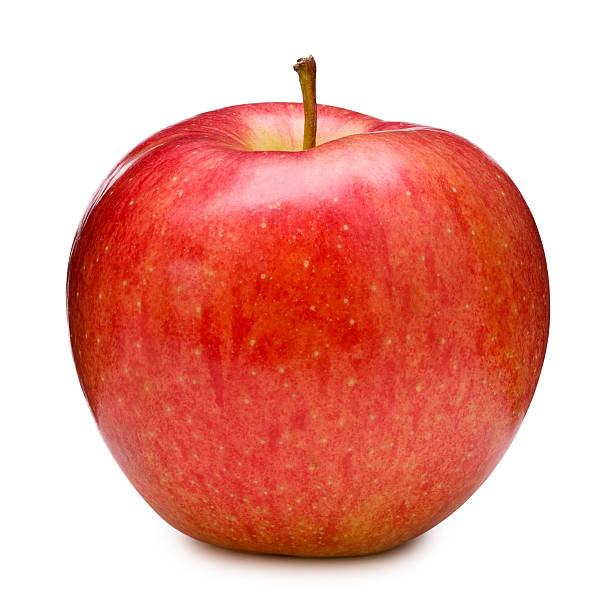

Loaded image: C:/Users/anass/Downloads/Apple1.jpg


In [24]:
from PIL import Image

# Step 1: Set your image path manually
img_path = "C:/Users/anass/Downloads/Apple1.jpg"  # <-- Replace with your image path

# Step 2: Load the image
img = Image.open(img_path)
display(img)  # Optional: display the image in the notebook

print(f"Loaded image: {img_path}")


# Apply Halftoning Methods

In [27]:
# Global Threshold
thresh_img = global_threshold(img)

# Ordered Dithering
ordered_2 = ordered_dither(img, 2)
ordered_4 = ordered_dither(img, 4)
ordered_8 = ordered_dither(img, 8)

# Error Diffusion
dither_fs = error_diffusion(img, FLOYD_STEINBERG)
dither_jarvis = error_diffusion(img, JARVIS)
dither_stucki = error_diffusion(img, STUCKI)

# Random Dithering
rand_img = random_dither(img)

# Blue-noise Dithering
blue_img = blue_noise_dither(img)

# CMYK Halftone Preview
cmyk_img = cmyk_halftone_preview(img)


# Display Results

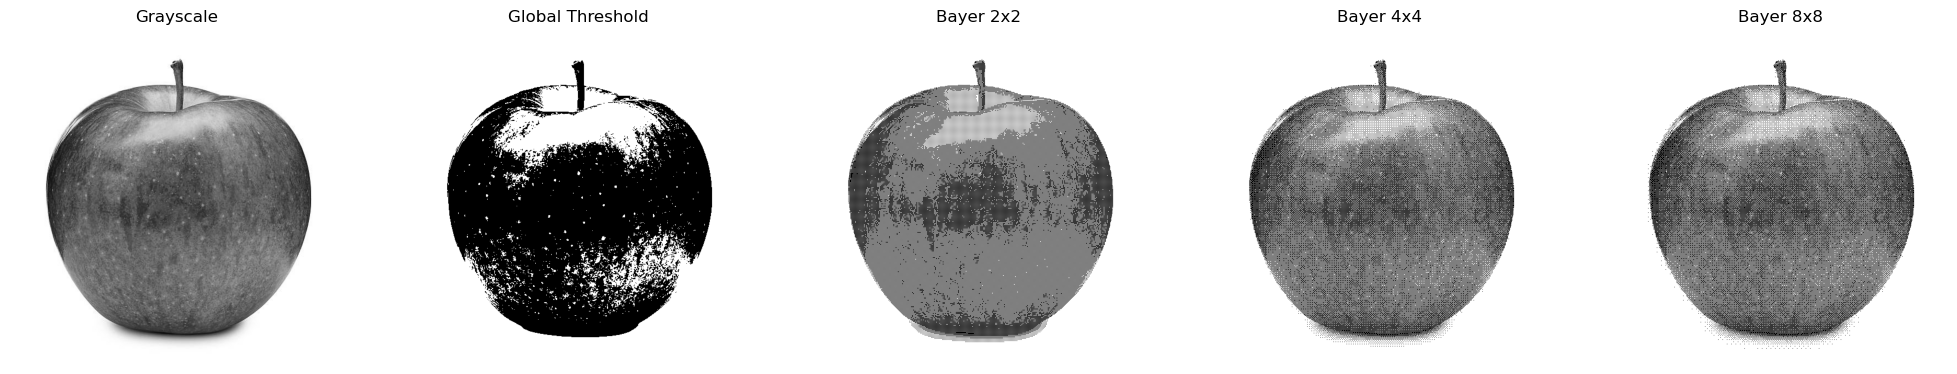

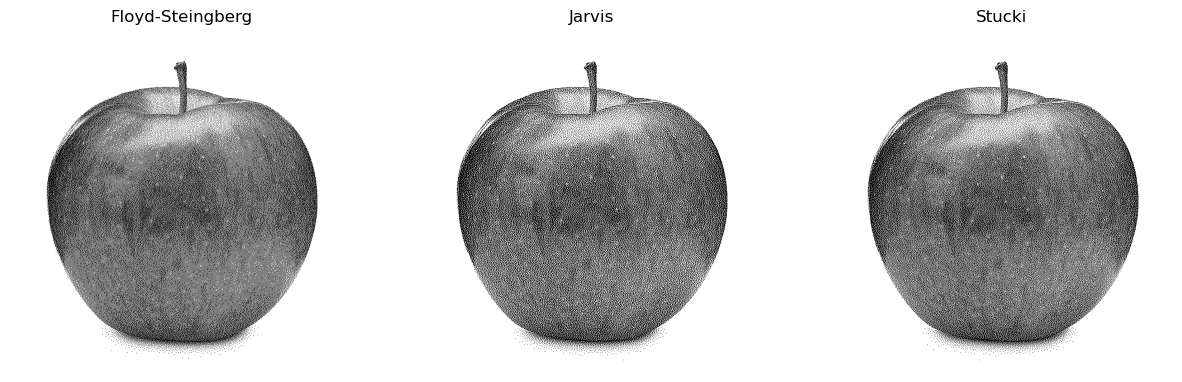

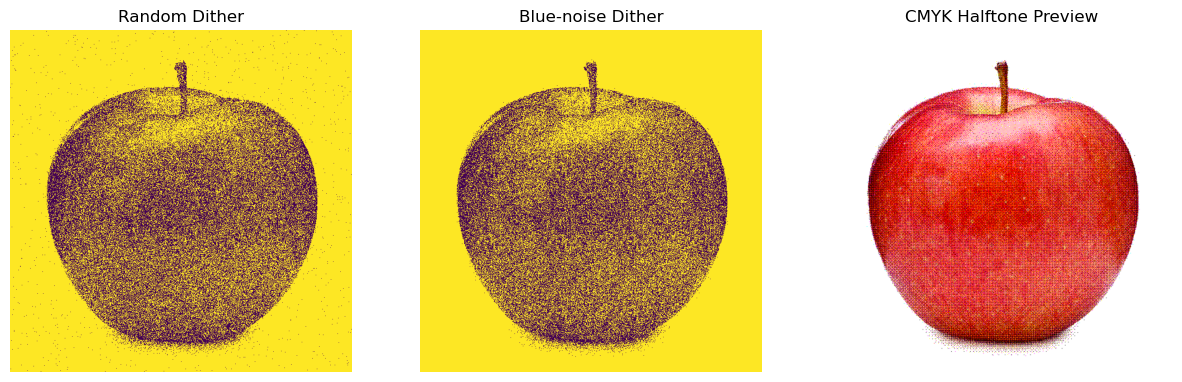

In [28]:
# Grayscale & Ordered Dithering
show_images([img.convert("L"), thresh_img, ordered_2, ordered_4, ordered_8],
            ["Grayscale", "Global Threshold", "Bayer 2x2", "Bayer 4x4", "Bayer 8x8"])

# Error Diffusion
show_images([dither_fs, dither_jarvis, dither_stucki],
            ["Floyd-Steingberg", "Jarvis", "Stucki"])

# Random, Blue-noise, CMYK
show_images([rand_img, blue_img, cmyk_img],
            ["Random Dither", "Blue-noise Dither", "CMYK Halftone Preview"], cmap=None)


In [29]:
import matplotlib.pyplot as plt

def show_image_with_title(img, title, font_size=20, color='darkblue'):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap='gray' if img.mode=='L' else None)
    plt.title(title, fontsize=font_size, fontweight='bold', color=color)
    plt.axis('off')
    plt.show()


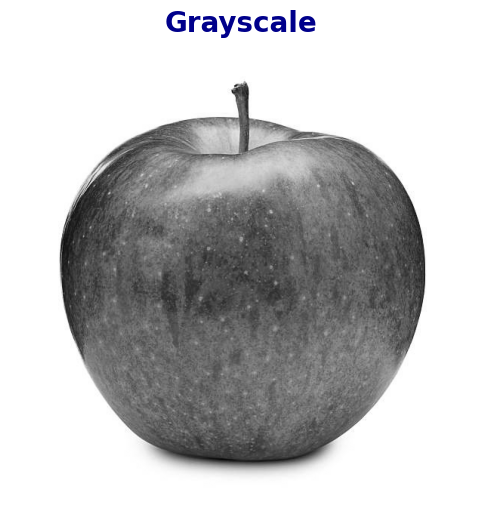

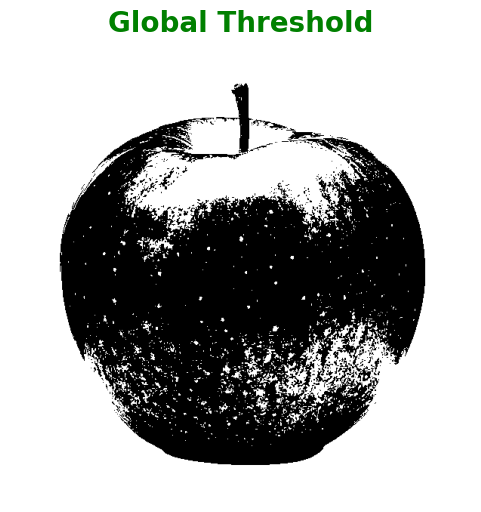

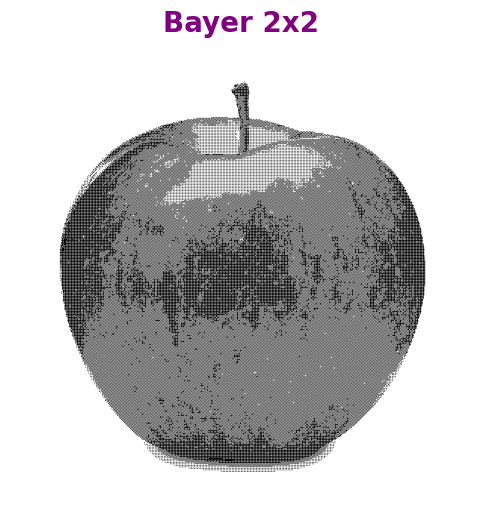

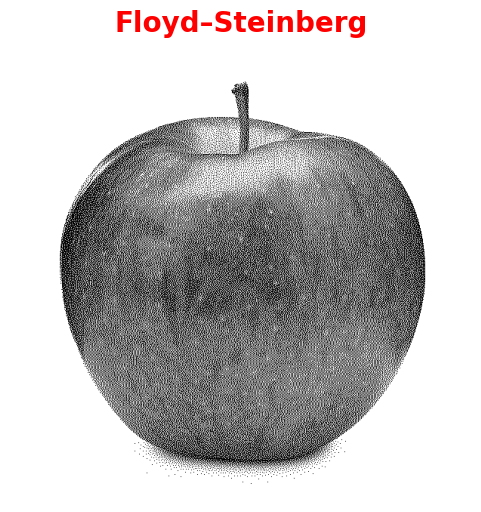

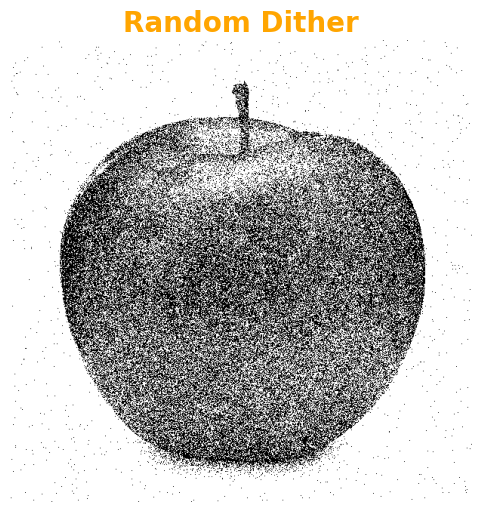

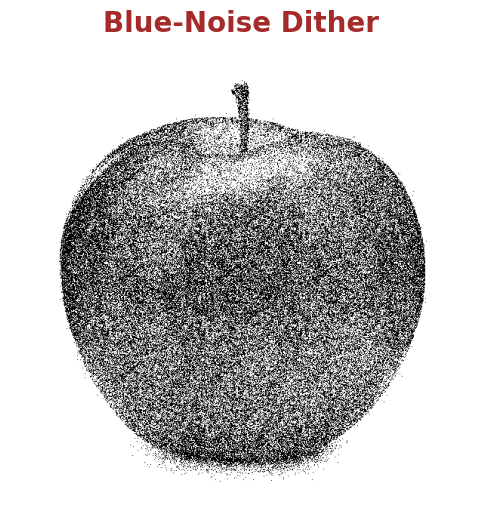

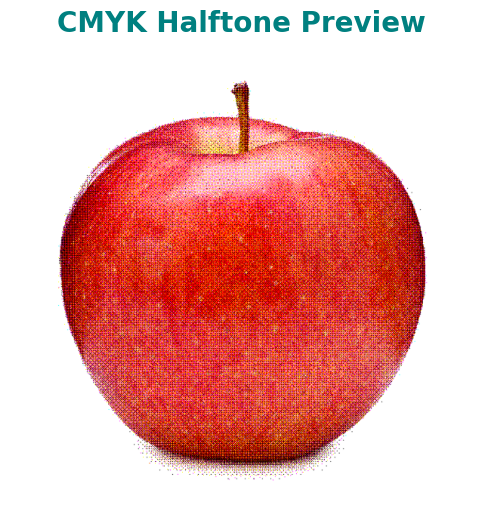

In [30]:
# Grayscale
show_image_with_title(img.convert("L"), "Grayscale")

# Global Threshold
show_image_with_title(thresh_img, "Global Threshold", color='green')

# Ordered Dithering 2x2
show_image_with_title(ordered_2, "Bayer 2x2", color='purple')

# Error Diffusion - Floyd-Steinberg
show_image_with_title(dither_fs, "Floyd–Steinberg", color='red')

# Random Dithering
show_image_with_title(rand_img, "Random Dither", color='orange')

# Blue-Noise Dithering
show_image_with_title(blue_img, "Blue-Noise Dither", color='brown')

# CMYK Halftone Preview
show_image_with_title(cmyk_img, "CMYK Halftone Preview", color='teal')


In [33]:
import os

# Create a folder to save results
output_folder = "C:/Users/anass/OneDrive/Desktop/Halftone Result Images"
os.makedirs(output_folder, exist_ok=True)

def show_and_save(img, title, filename, font_size=20, color='darkblue'):
    # Display the image with styled title
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap='gray' if img.mode=='L' else None)
    plt.title(title, fontsize=font_size, fontweight='bold', color=color)
    plt.axis('off')
    plt.show()
    
    # Save the image
    save_path = os.path.join(output_folder, filename)
    img.save(save_path)
    print(f"Saved image: {save_path}")


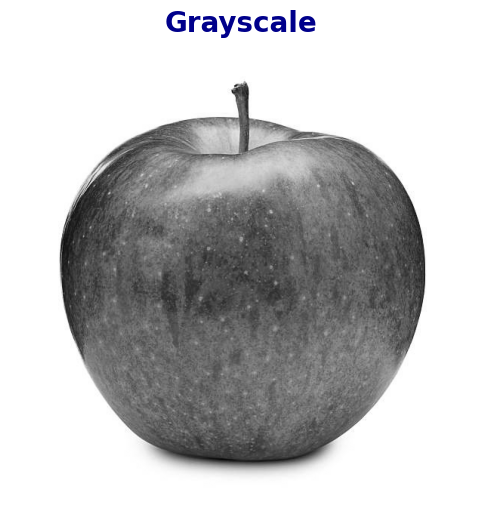

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\grayscale.png


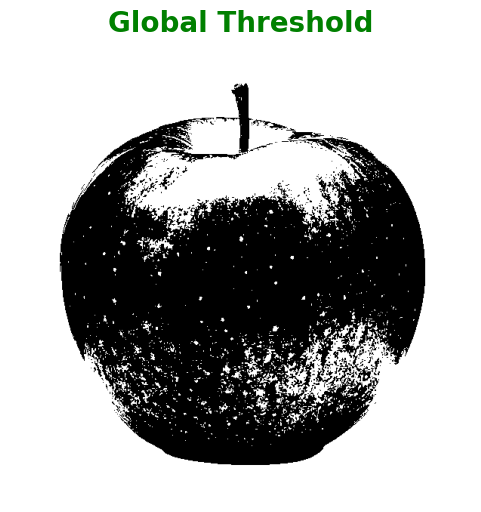

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\global_threshold.png


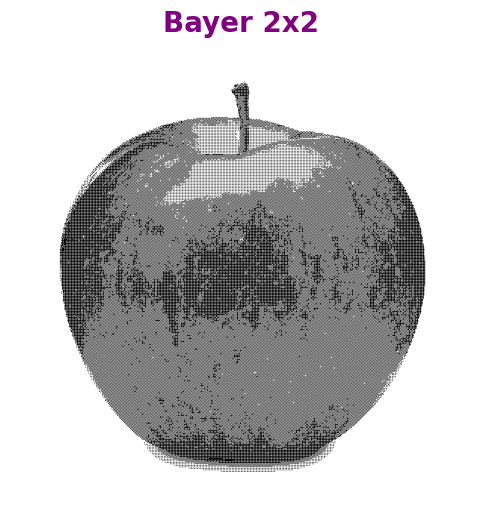

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\bayer_2x2.png


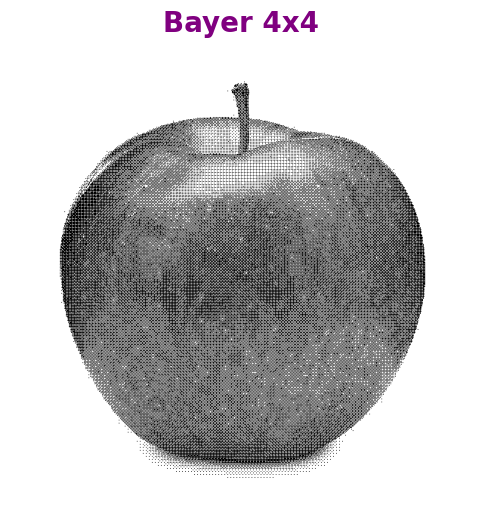

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\bayer_4x4.png


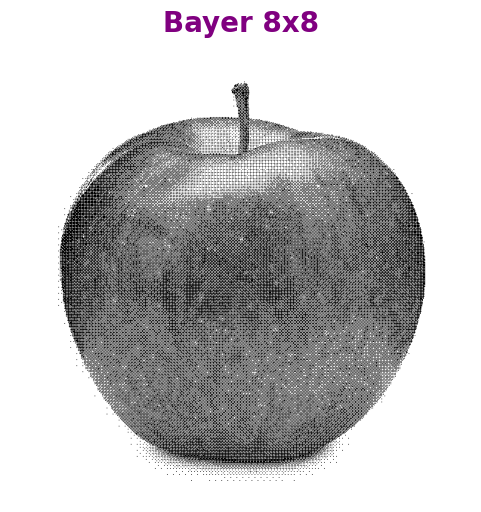

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\bayer_8x8.png


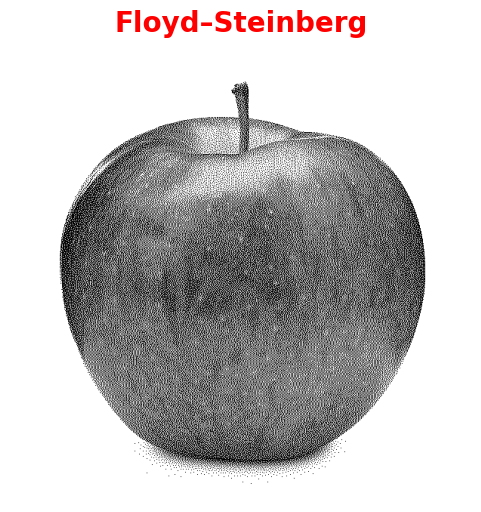

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\floyd_steinberg.png


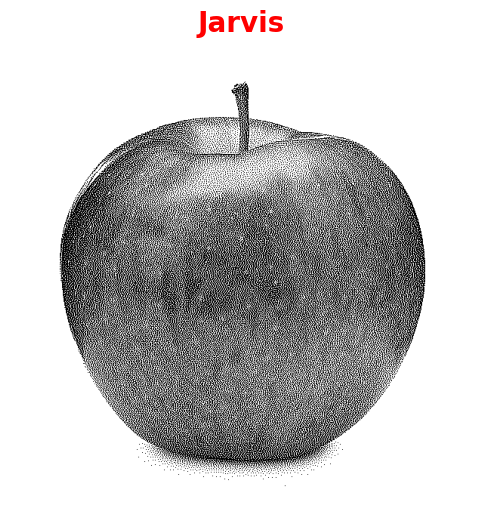

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\jarvis.png


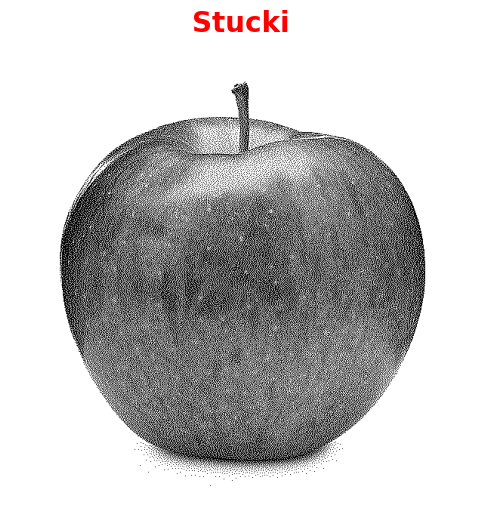

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\stucki.png


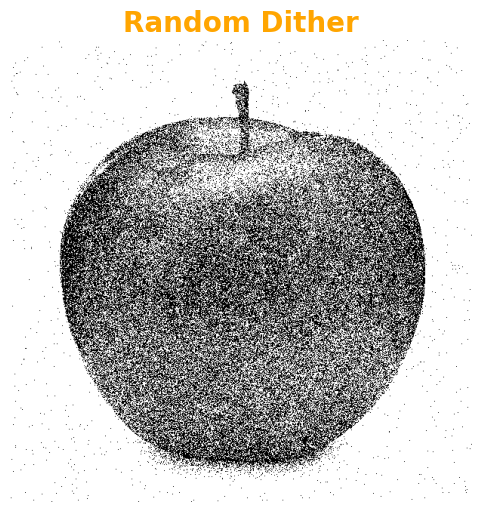

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\random_dither.png


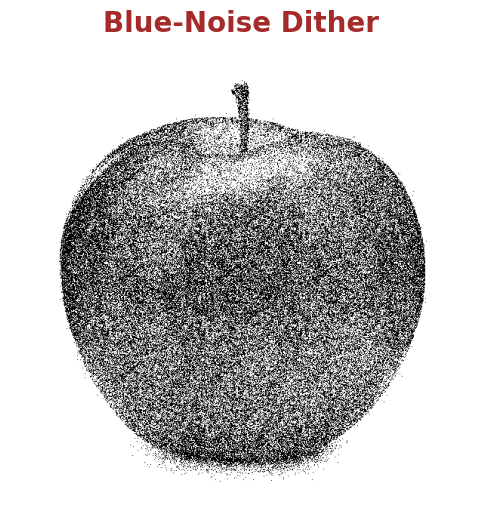

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\blue_noise.png


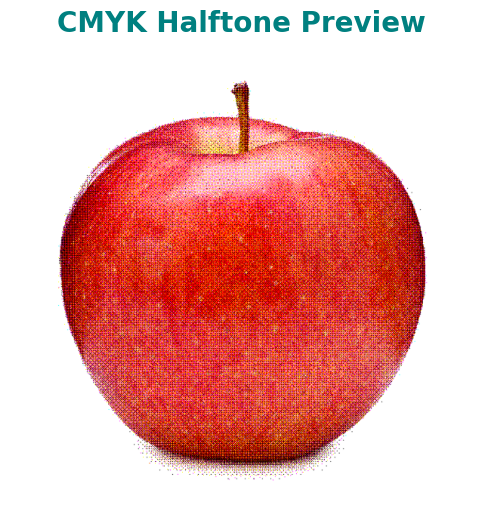

Saved image: C:/Users/anass/OneDrive/Desktop/Halftone Result Images\cmyk_halftone.png


In [34]:
# Grayscale
show_and_save(img.convert("L"), "Grayscale", "grayscale.png")

# Global Threshold
show_and_save(thresh_img, "Global Threshold", "global_threshold.png", color='green')

# Ordered Dithering
show_and_save(ordered_2, "Bayer 2x2", "bayer_2x2.png", color='purple')
show_and_save(ordered_4, "Bayer 4x4", "bayer_4x4.png", color='purple')
show_and_save(ordered_8, "Bayer 8x8", "bayer_8x8.png", color='purple')

# Error Diffusion
show_and_save(dither_fs, "Floyd–Steinberg", "floyd_steinberg.png", color='red')
show_and_save(dither_jarvis, "Jarvis", "jarvis.png", color='red')
show_and_save(dither_stucki, "Stucki", "stucki.png", color='red')

# Random Dithering
show_and_save(rand_img, "Random Dither", "random_dither.png", color='orange')

# Blue-Noise Dithering
show_and_save(blue_img, "Blue-Noise Dither", "blue_noise.png", color='brown')

# CMYK Halftone Preview
show_and_save(cmyk_img, "CMYK Halftone Preview", "cmyk_halftone.png", color='teal')
